# CSE4088 Machine Learning

## Göksel Tokur - 150116049

## Merve Ayer - 150119828

In [43]:
import pandas as pd
import os
import time
from datetime import timedelta, datetime
from dateutil import parser
import math
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Read Collected Data from CSV

In [44]:
df = pd.read_csv('data/BTCUSDT-1m-1Jun2020to1Dec2020data.csv')
df.head()

df.tail(10)

,Timestamp,Open,High,Low,Close,Volume,Close_time,Quote_av,Trades,Tb_base_av,Tb_quote_av,Ignore
263242,2020-11-30 23:52:00,19744.00,19744.99,19740.22,19744.48,60.573448,1606780379999,1.195970e+06,986,41.370690,8.168287e+05,0
263243,2020-11-30 23:53:00,19744.49,19744.99,19699.52,19718.28,119.123054,1606780439999,2.349155e+06,1683,68.558198,1.351917e+06,0
263244,2020-11-30 23:54:00,19718.28,19736.03,19625.05,19641.37,97.284917,1606780499999,1.915027e+06,2217,37.528715,7.392528e+05,0
263245,2020-11-30 23:55:00,19641.37,19697.58,19637.04,19663.31,112.950287,1606780559999,2.221748e+06,2162,65.823884,1.294934e+06,0
263246,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827,1606780619999,1.579052e+06,1776,34.951323,6.869545e+05,0
263247,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503,1606780679999,1.143874e+06,1151,29.788851,5.858160e+05,0
263248,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943,1606780739999,1.665254e+06,1482,31.676067,6.227900e+05,0
263249,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571,1606780799999,2.693831e+06,1708,95.473753,1.879199e+06,0
263250,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435,1606780859999,2.681137e+06,1828,72.113618,1.420672e+06,0
263251,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435,1606780859999,2.681137e+06,1828,72.113618,1.420672e+06,0


In [45]:
# Check is there a missing value
print('Is there a missing value? - ',df.isnull().values.any())

Is there a missing value? -  False


In [46]:
# Drop columns that we won't use
df = df.drop('Close_time', 1)
df = df.drop('Quote_av', 1)
df = df.drop('Trades', 1)
df = df.drop('Tb_base_av', 1)
df = df.drop('Tb_quote_av', 1)
df = df.drop('Ignore', 1)

df.tail(10)

,Timestamp,Open,High,Low,Close,Volume
263242,2020-11-30 23:52:00,19744.00,19744.99,19740.22,19744.48,60.573448
263243,2020-11-30 23:53:00,19744.49,19744.99,19699.52,19718.28,119.123054
263244,2020-11-30 23:54:00,19718.28,19736.03,19625.05,19641.37,97.284917
263245,2020-11-30 23:55:00,19641.37,19697.58,19637.04,19663.31,112.950287
263246,2020-11-30 23:56:00,19663.25,19672.28,19635.00,19656.01,80.342827
263247,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503
263248,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943
263249,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571
263250,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435
263251,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435


In [47]:
'''
from sklearn.preprocessing import MinMaxScaler


#Columns of price data to use
columns = ['Close', 'Open', 'High', 'Low', 'Volume']

scaler = MinMaxScaler()
# normalization
for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
    
df.tail(10)
'''

"\nfrom sklearn.preprocessing import MinMaxScaler\n\n\n#Columns of price data to use\ncolumns = ['Close', 'Open', 'High', 'Low', 'Volume']\n\nscaler = MinMaxScaler()\n# normalization\nfor c in columns:\n    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))\n    \ndf.tail(10)\n"

# Sampling

In [48]:
# Produce training samples to predict future from past.
def sampler(P, F, A, sliding_window=True):
    number_of_samples = P + F
    
    if sliding_window:
        I = np.arange(number_of_samples) + np.arange(A.shape[0] - number_of_samples + 1).reshape(-1, 1)
    else:
        if A.shape[0] % number_of_samples == 0:
            I = np.arange(number_of_samples) + np.arange(0, A.shape[0], number_of_samples).reshape(-1, 1)
        else:
            I = np.arange(number_of_samples) + np.arange(0, A.shape[0] - number_of_samples, number_of_samples).reshape(-1, 1)
            
    B = A[I].reshape(-1, number_of_samples * A.shape[1], A.shape[2])
    number_of_features = P * A.shape[1]
    sample_matrix = B[:, :number_of_features]
    target_matrix = B[:, number_of_features:]
    
    return sample_matrix, target_matrix


data_file = 'data/BTCUSDT-1m-1Jun2020to1Dec2020data.csv'
df = pd.read_csv(data_file)

# Drop columns that we won't use
df = df.drop('Close_time', 1)
df = df.drop('Quote_av', 1)
df = df.drop('Trades', 1)
df = df.drop('Tb_base_av', 1)
df = df.drop('Tb_quote_av', 1)
df = df.drop('Ignore', 1)

df.tail(10)

number_of_backwards = 256
number_of_forwards = 16

test_df = df[-(number_of_backwards + number_of_forwards):]

df = df[:len(df)-(number_of_backwards + number_of_forwards)]


print(df)
test_df

                  Timestamp      Open      High       Low     Close     Volume
0       2020-06-01 00:00:00   9448.27   9451.74   9432.76   9439.58  75.478449
1       2020-06-01 00:01:00   9438.17   9446.20   9431.75   9442.04  71.846860
2       2020-06-01 00:02:00   9442.04   9446.66   9431.47   9443.08  36.138885
3       2020-06-01 00:03:00   9443.08   9450.00   9421.67   9421.86  46.749705
4       2020-06-01 00:04:00   9424.25   9435.22   9422.24   9432.64  40.447054
...                     ...       ...       ...       ...       ...        ...
262975  2020-11-30 19:25:00  19279.66  19300.00  19279.66  19295.01  63.166917
262976  2020-11-30 19:26:00  19295.01  19310.00  19279.66  19309.51  83.665927
262977  2020-11-30 19:27:00  19308.56  19310.00  19282.16  19291.61  56.956399
262978  2020-11-30 19:28:00  19291.62  19300.00  19282.16  19295.53  23.787360
262979  2020-11-30 19:29:00  19295.54  19300.10  19293.21  19299.89  35.919617

[262980 rows x 6 columns]


,Timestamp,Open,High,Low,Close,Volume
262980,2020-11-30 19:30:00,19299.89,19315.00,19200.77,19211.54,133.579779
262981,2020-11-30 19:31:00,19211.55,19231.86,19200.88,19219.18,95.678271
262982,2020-11-30 19:32:00,19219.18,19255.50,19216.35,19251.39,36.612857
262983,2020-11-30 19:33:00,19252.36,19252.36,19225.10,19231.58,35.311294
262984,2020-11-30 19:34:00,19231.58,19237.30,19218.35,19226.64,39.491231
...,...,...,...,...,...,...
263247,2020-11-30 23:57:00,19656.01,19686.37,19650.00,19655.99,58.163503
263248,2020-11-30 23:58:00,19656.10,19679.00,19647.83,19658.33,84.698943
263249,2020-11-30 23:59:00,19658.33,19700.00,19656.82,19695.87,136.845571
263250,2020-12-01 00:00:00,19695.87,19720.00,19675.43,19715.93,136.104435


In [49]:
columns = ['Close']
o_df = df
time_stamps = df['Timestamp']
df = df.loc[:,columns]
real_df = o_df.loc[:,columns]

real_df

,Close
0,9439.58
1,9442.04
2,9443.08
3,9421.86
4,9432.64
...,...
262975,19295.01
262976,19309.51
262977,19291.61
262978,19295.53


### Normalize The Data with MinMax Normalization

In [50]:
# Normalize the data with min - max normalization
scaler = MinMaxScaler()

for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
    
df

,Close
0,0.052724
1,0.052948
2,0.053043
3,0.051110
4,0.052092
...,...
262975,0.950290
262976,0.951611
262977,0.949981
262978,0.950338


In [51]:


# Features are backward sample dimensions
close_data = np.array(df)[:,None,:]
print('A', close_data)

real_close_data = np.array(real_df)[:,None,:]
print('real_A', real_close_data)

time_stamps = np.array(time_stamps)[:,None,None]
print('time_stamps', time_stamps)

number_of_backwards = 256
number_of_forwards = 16

# Pass preprocessed close data to the sampler
X, y = sampler(number_of_backwards, number_of_forwards, close_data, sliding_window=False)
print('Data', X)
print('Labels', y)

# Pass timestamps to the sampler
backward_times, forward_times = sampler(number_of_backwards, number_of_forwards, time_stamps, sliding_window=False)

# Pass real close data to the sampler
real_X, real_Y = sampler(number_of_backwards, number_of_forwards, real_close_data, sliding_window=False)

real_close_data = np.array(real_df)
real_backwards = np.array(real_X)
real_forwards = np.array(real_Y)


A [[[0.05272414]]

 [[0.05294818]]

 [[0.05304289]]

 ...

 [[0.94998074]]

 [[0.95033775]]

 [[0.95073482]]]
real_A [[[ 9439.58]]

 [[ 9442.04]]

 [[ 9443.08]]

 ...

 [[19291.61]]

 [[19295.53]]

 [[19299.89]]]
time_stamps [[['2020-06-01 00:00:00']]

 [['2020-06-01 00:01:00']]

 [['2020-06-01 00:02:00']]

 ...

 [['2020-11-30 19:27:00']]

 [['2020-11-30 19:28:00']]

 [['2020-11-30 19:29:00']]]
Data [[[0.05272414]
  [0.05294818]
  [0.05304289]
  ...
  [0.06523578]
  [0.06549261]
  [0.06669478]]

 [[0.06359373]
  [0.063489  ]
  [0.06332507]
  ...
  [0.06256187]
  [0.0623269 ]
  [0.06249812]]

 [[0.06268938]
  [0.0625983 ]
  [0.06231689]
  ...
  [0.06332507]
  [0.06257371]
  [0.06332689]]

 ...

 [[0.87057577]
  [0.86975794]
  [0.86957033]
  ...
  [0.88325408]
  [0.88235792]
  [0.87995996]]

 [[0.88523402]
  [0.88464295]
  [0.88527955]
  ...
  [0.88023409]
  [0.87946088]
  [0.87898275]]

 [[0.88589066]
  [0.88716022]
  [0.88868023]
  ...
  [0.98774245]
  [0.98518056]
  [0.98133818]]]
La

In [52]:
import pandas as pd
import numpy as numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, LeakyReLU
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint
import os
import tensorflow as tf


output_file_name = 'BTCUSDT-1m'

step_size = X.shape[1]
batch_size= 8
nb_features = X.shape[2]

epochs = 20

# Split training data and validation data %80 -> training
training_size = int(X.shape[0] * 0.8)
Xt = X[:training_size,:]
yt = y[:training_size,:]
Xv = X[training_size:,:]
yv = y[training_size:,:]


# Neural Network
model = Sequential()


# 2 layers
print((step_size, nb_features))
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
model.add(Dropout(0.25))
model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))


'''
# 3 Layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=8))

# 4 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=2))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=2))
'''

model.compile(loss='mse', optimizer='adam')
model.fit(Xt, yt, verbose=1, batch_size=batch_size, validation_data=(Xv, yv), epochs = epochs, callbacks=[CSVLogger(output_file_name+'.csv', append=True), ModelCheckpoint('models/'+'best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')])


(256, 1)
Epoch 1/20
97/97 [==============================] - 1s 4ms/step - loss: 0.0215 - val_loss: 0.0107

Epoch 00001: val_loss improved from inf to 0.01071, saving model to models/best_model.hdf5
Epoch 2/20
97/97 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0099

Epoch 00002: val_loss improved from 0.01071 to 0.00988, saving model to models/best_model.hdf5
Epoch 3/20
97/97 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0081

Epoch 00003: val_loss improved from 0.00988 to 0.00809, saving model to models/best_model.hdf5
Epoch 4/20
97/97 [==============================] - 0s 3ms/step - loss: 7.4077e-04 - val_loss: 0.0037

Epoch 00004: val_loss improved from 0.00809 to 0.00369, saving model to models/best_model.hdf5
Epoch 5/20
97/97 [==============================] - 0s 3ms/step - loss: 6.2569e-04 - val_loss: 0.0012

Epoch 00005: val_loss improved from 0.00369 to 0.00117, saving model to models/best_model.hdf5
Epoch 6/20
97/97 

# Load model

In [53]:
model.load_weights('models/best_model.hdf5')
model.compile(loss='mse', optimizer='adam')

# Change Variable Names

In [54]:
import matplotlib.pyplot as plt

# Split training data and validation data %80 -> training
training_size = int(X.shape[0] * 0.8)

close_data_val = X[training_size:,:,:]
print('close_data_val', close_data_val)
real_forwards_val = real_forwards[training_size:,:,:]
real_backwards_val = real_backwards[training_size:,:,:]
backward_times_val = backward_times[training_size:,:,:]
forward_times_val = forward_times[training_size:,:,:]



real_chart = np.append(real_backwards_val, real_forwards_val, axis=1)
print('real_chart', real_chart[0].shape,  (real_chart[0])[0].shape)
real_chart_times = np.append(backward_times_val, forward_times_val, axis=1)
print('real_chart_times', real_chart_times)


print('close_data_val' ,close_data_val[0].shape)
predicted = model.predict(close_data_val)
predicted_inverted = []
print('predicted', predicted)



# Inverse Transform (Min-Max Scaler)
for i in range(real_close_data.shape[1]):
    # 1D vector of the real data
    scaler.fit(real_close_data[:,i].reshape(-1,1))
    print('real_close_data[:,i]', real_close_data[:,i])
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
    print('predicted[:,:,i]', predicted[:,:,i])
    print('predicted_inverted', predicted_inverted)
    

# Get real_close values as 1D Vector
real_chart = real_chart[:,:,0].reshape(-1)
print('real_chart', real_chart)
real_chart_times = real_chart_times.reshape(-1)
print(real_chart_times)
real_chart_times = pd.to_datetime(real_chart_times, unit='ns')


print(np.array(predicted_inverted)[0].shape)
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print(np.array(predicted_inverted).shape)
forward_times_val = pd.to_datetime(forward_times_val.reshape(-1), unit='ns')

close_data_val [[[0.38547855]
  [0.38538292]
  [0.38543119]
  ...
  [0.39094568]
  [0.39087009]
  [0.3909475 ]]

 [[0.40347554]
  [0.40539901]
  [0.40641447]
  ...
  [0.37946407]
  [0.37878011]
  [0.37862893]]

 [[0.37696684]
  [0.37673552]
  [0.37570821]
  ...
  [0.37451242]
  [0.37438218]
  [0.37475012]]

 ...

 [[0.87057577]
  [0.86975794]
  [0.86957033]
  ...
  [0.88325408]
  [0.88235792]
  [0.87995996]]

 [[0.88523402]
  [0.88464295]
  [0.88527955]
  ...
  [0.88023409]
  [0.87946088]
  [0.87898275]]

 [[0.88589066]
  [0.88716022]
  [0.88868023]
  ...
  [0.98774245]
  [0.98518056]
  [0.98133818]]]
real_chart (272, 1) (1,)
real_chart_times [[['2020-10-24 23:14:00']
  ['2020-10-24 23:15:00']
  ['2020-10-24 23:16:00']
  ...
  ['2020-10-25 03:43:00']
  ['2020-10-25 03:44:00']
  ['2020-10-25 03:45:00']]

 [['2020-10-25 03:46:00']
  ['2020-10-25 03:47:00']
  ['2020-10-25 03:48:00']
  ...
  ['2020-10-25 08:15:00']
  ['2020-10-25 08:16:00']
  ['2020-10-25 08:17:00']]

 [['2020-10-25 08:18:

In [55]:
real_chart_df = pd.DataFrame()
real_chart_df['times'] = real_chart_times
real_chart_df['value'] = real_chart

prediction_df = pd.DataFrame()
prediction_df['times'] = forward_times_val
print(predicted_inverted)
prediction_df['value'] = predicted_inverted




[13132.63  13133.173 13135.606 ... 19201.668 19288.668 19393.46 ]


Mean Squared Error =  25274.586041184124


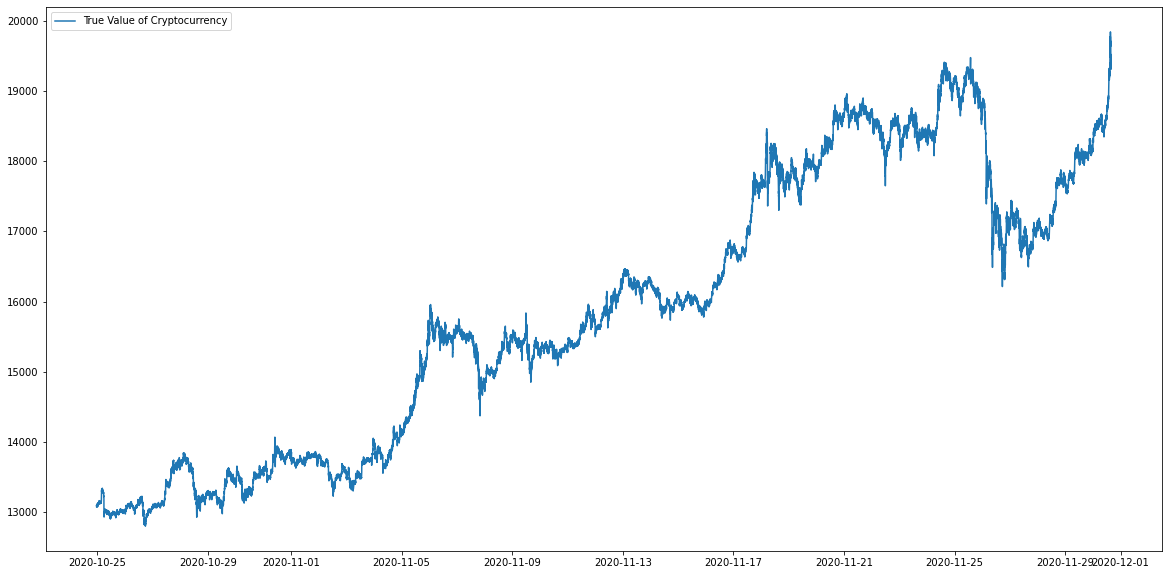

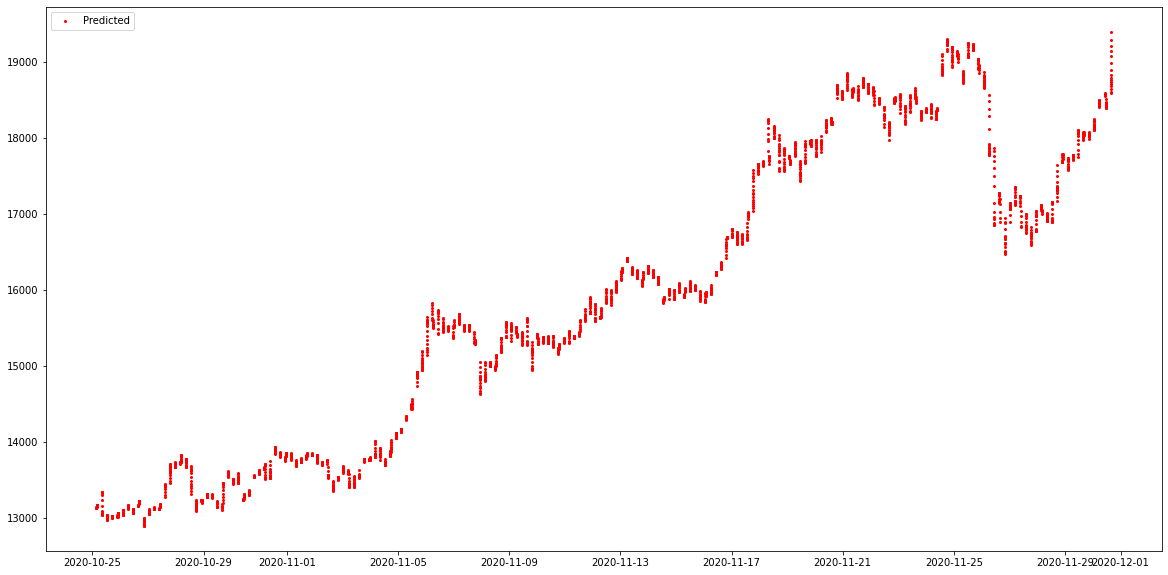

,times,value
3004,2020-11-29 11:26:00,18078.189453
3005,2020-11-29 11:27:00,18073.904297
3006,2020-11-29 11:28:00,18077.634766
3007,2020-11-29 11:29:00,18087.851562
3008,2020-11-29 15:46:00,18026.640625
...,...,...
3099,2020-11-30 15:37:00,19074.300781
3100,2020-11-30 15:38:00,19144.759766
3101,2020-11-30 15:39:00,19201.667969
3102,2020-11-30 15:40:00,19288.667969


In [63]:
print("Mean Squared Error = ", mean_squared_error(real_forwards_val[:,:,0].reshape(-1), predicted_inverted))
plt.figure(figsize=(20,10))
plt.plot(real_chart_df.times, real_chart_df.value, label = 'True Value of Cryptocurrency')
plt.legend(loc='upper left')
plt.savefig('base.png')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(prediction_df.times, prediction_df.value, 'ro', label='Predicted', markersize=2)
plt.legend(loc='upper left')
plt.savefig('cnn.png')
plt.show()

prediction_df.tail(100)

In [57]:
real_chart_df

,times,value
0,2020-10-24 23:14:00,13093.28
1,2020-10-24 23:15:00,13092.23
2,2020-10-24 23:16:00,13092.76
3,2020-10-24 23:17:00,13091.21
4,2020-10-24 23:18:00,13088.65
...,...,...
52763,2020-11-30 15:37:00,19456.34
52764,2020-11-30 15:38:00,19519.99
52765,2020-11-30 15:39:00,19490.02
52766,2020-11-30 15:40:00,19476.37


In [58]:
# Get real_close_values
future_predict = pd.DataFrame(test_df['Close'])
columns = ['Close']
real_test_df = test_df.loc[:,columns]

real_future_predict = np.array(real_test_df)[:,None,:]

scaler = MinMaxScaler()
# Scale minmax transform
for c in columns:
    future_predict[c] = scaler.fit_transform(future_predict[c].values.reshape(-1,1))

# Get last backwards 256
future_predict = np.array([future_predict[:256]])
print('Backward input shape: ',future_predict[0].shape)

# Predict
predicted_future = model.predict(future_predict)

# Inverse Transform
predicted_future_inverted = []
for i in range(real_future_predict.shape[1]):
    print('RR', real_future_predict[:,i].reshape(-1, 1))
    scaler.fit(real_future_predict[:,i].reshape(-1, 1))
    predicted_future_inverted.append(scaler.inverse_transform(predicted_future[:,:,i]))
    

predicted_future_inverted = np.array(predicted_future_inverted)
print(predicted_future_inverted)

print((predicted_future_inverted[0])[0])
future_df = pd.DataFrame()
future_df['value'] =  (predicted_future_inverted[0])[0]

future_df



Backward input shape:  (256, 1)
RR [[19211.54]
 [19219.18]
 [19251.39]
 [19231.58]
 [19226.64]
 [19220.01]
 [19216.35]
 [19206.33]
 [19218.89]
 [19223.8 ]
 [19191.95]
 [19184.33]
 [19213.72]
 [19249.14]
 [19235.46]
 [19263.6 ]
 [19241.36]
 [19214.57]
 [19218.94]
 [19226.71]
 [19224.55]
 [19245.7 ]
 [19258.89]
 [19286.23]
 [19262.9 ]
 [19241.51]
 [19201.96]
 [19214.75]
 [19212.6 ]
 [19259.98]
 [19177.79]
 [19180.23]
 [19196.62]
 [19197.59]
 [19219.5 ]
 [19291.98]
 [19330.4 ]
 [19327.82]
 [19371.46]
 [19405.77]
 [19399.5 ]
 [19381.73]
 [19366.44]
 [19382.49]
 [19378.9 ]
 [19365.89]
 [19361.84]
 [19337.83]
 [19370.  ]
 [19369.8 ]
 [19367.12]
 [19399.6 ]
 [19383.4 ]
 [19382.68]
 [19376.56]
 [19366.74]
 [19383.91]
 [19405.86]
 [19422.17]
 [19417.03]
 [19429.67]
 [19392.84]
 [19396.8 ]
 [19435.02]
 [19439.  ]
 [19429.99]
 [19452.8 ]
 [19444.31]
 [19451.42]
 [19452.99]
 [19467.99]
 [19455.  ]
 [19437.53]
 [19412.53]
 [19427.19]
 [19425.77]
 [19413.96]
 [19415.87]
 [19391.05]
 [19386.23]
 [194

,value
0,19299.648438
1,19345.873047
2,19391.830078
3,19412.314453
4,19433.230469
5,19453.380859
6,19456.859375
7,19452.976562
8,19428.140625
9,19385.351562


In [59]:

'''
from datetime import datetime
from datetime import timedelta


last_date_of_the_graph = np.array(pd.to_datetime(o_df['Timestamp'], unit='ns'))[-1]

dt_obj = datetime.strptime(str(last_date_of_the_graph)[:-4], "%Y-%m-%dT%H:%M:%S.%f")
dt_obj

dates = []


dt_obj += timedelta(seconds=60)
for i in range(16):
    dates.append(datetime.timestamp(dt_obj))
    dt_obj += timedelta(seconds=60)

    
    
timess = pd.DataFrame()
timess['times'] = dates
#dates = pd.DataFrame(np.array(dates).reshape(-1))
#future_df['times'] = pd.to_datetime(dates, unit='ns')
timess['times']
'''


'\nfrom datetime import datetime\nfrom datetime import timedelta\n\n\nlast_date_of_the_graph = np.array(pd.to_datetime(o_df[\'Timestamp\'], unit=\'ns\'))[-1]\n\ndt_obj = datetime.strptime(str(last_date_of_the_graph)[:-4], "%Y-%m-%dT%H:%M:%S.%f")\ndt_obj\n\ndates = []\n\n\ndt_obj += timedelta(seconds=60)\nfor i in range(16):\n    dates.append(datetime.timestamp(dt_obj))\n    dt_obj += timedelta(seconds=60)\n\n    \n    \ntimess = pd.DataFrame()\ntimess[\'times\'] = dates\n#dates = pd.DataFrame(np.array(dates).reshape(-1))\n#future_df[\'times\'] = pd.to_datetime(dates, unit=\'ns\')\ntimess[\'times\']\n'

16
0    2020-11-30 23:46:00
1    2020-11-30 23:47:00
2    2020-11-30 23:48:00
3    2020-11-30 23:49:00
4    2020-11-30 23:50:00
5    2020-11-30 23:51:00
6    2020-11-30 23:52:00
7    2020-11-30 23:53:00
8    2020-11-30 23:54:00
9    2020-11-30 23:55:00
10   2020-11-30 23:56:00
11   2020-11-30 23:57:00
12   2020-11-30 23:58:00
13   2020-11-30 23:59:00
14   2020-12-01 00:00:00
15   2020-12-01 00:00:00
Name: timestamps, dtype: datetime64[ns]
AAAA
AAAA


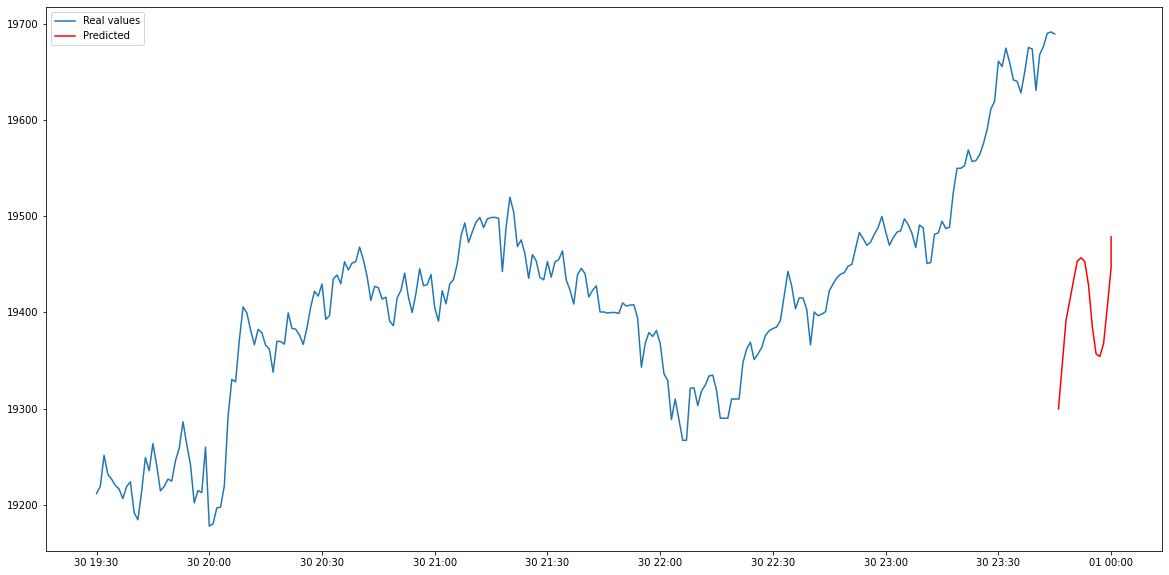

0    2020-11-30 23:46:00
1    2020-11-30 23:47:00
2    2020-11-30 23:48:00
3    2020-11-30 23:49:00
4    2020-11-30 23:50:00
5    2020-11-30 23:51:00
6    2020-11-30 23:52:00
7    2020-11-30 23:53:00
8    2020-11-30 23:54:00
9    2020-11-30 23:55:00
10   2020-11-30 23:56:00
11   2020-11-30 23:57:00
12   2020-11-30 23:58:00
13   2020-11-30 23:59:00
14   2020-12-01 00:00:00
15   2020-12-01 00:00:00
Name: timestamps, dtype: datetime64[ns]


In [60]:
o_df_2048 = test_df[:256]

real_8192 = pd.DataFrame()
real_8192['timestamps'] = pd.to_datetime(np.array(o_df_2048['Timestamp']).reshape(-1), unit='ns')
real_8192['close'] = np.array(o_df_2048['Close'])

o_df_512_256 = test_df[-16:]
print(len(o_df_512_256['Timestamp']))
time_512_256 = pd.DataFrame()
time_512_256['timestamps'] = pd.to_datetime(np.array(o_df_512_256['Timestamp']).reshape(-1), unit='ns')
print(time_512_256['timestamps'])
print("AAAA")

plt.figure(figsize=(20, 10))
print("AAAA")
plt.plot(real_8192.timestamps, real_8192.close, label='Real values')

#plt.plot(real_chart_df.times, real_chart_df.value, label = 'Actual')
plt.plot(time_512_256.timestamps, future_df.value, color='red', label='Predicted', markersize=2)
plt.legend(loc='upper left')
plt.savefig('cnn-Future.png')
plt.show()

prediction_df['times'][0]
print(time_512_256['timestamps'])

In [61]:
print("Mean squared error of prediction on test dataset = ", mean_squared_error(np.array(test_df[256:272]['Close']).tolist(), np.array(future_df['value']).tolist()))

Mean squared error of prediction on test dataset =  91224.75943077267
